In [3]:
import os, sys
from glob import glob
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.optimize import minimize
from tqdm import *
from astropy.cosmology import WMAP9

from grf.pk_interp import PowerSpectrumGridInterpolator

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# Load plot style

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


The arrays in `../data/pk_arys/` are computed by running `grf/gen_pk.py` through the interface `cluster/../data/pk_arys/`.

# 1. Load and save vanilla pre-computed PSs from `CLASS`

In [3]:
z_compute_ary = np.logspace(-3, 3, 500)
k_ary = np.logspace(-4, np.log10(1e3), 500)

log_pk_lin_baryon_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_pk_lin_baryon_k3_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_pk_nonlin_matter_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_pk_lin_matter_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))

for i_z, z_compute in enumerate(tqdm_notebook(z_compute_ary)):
    ary = np.load("../data/pk_arys/p_k_k_max_5000_z_" + str(i_z) + ".npz")
    interp_lin_baryon = interp1d(np.log10(ary['k_ary']), np.log10(ary['Pk_b_ary']), bounds_error=False, fill_value="extrapolate")
    interp_lin_baryon_k3 = interp1d(np.log10(ary['k_ary'][ary['k_ary'] < 10]), np.log10(ary['Pk_b_ary'])[ary['k_ary'] < 10], bounds_error=False, fill_value="extrapolate")
    interp_nonlin_matter = interp1d(np.log10(ary['k_ary']), np.log10(ary['Pk_tot_nonlin_ary']))
    interp_lin_matter = interp1d(np.log10(ary['k_ary']), np.log10(ary['Pk_tot_lin_ary']))
    log_pk_lin_baryon_grid_ary[i_z,:] = (interp_lin_baryon(np.log10(k_ary)))
    log_pk_lin_baryon_k3_grid_ary[i_z,:] = (interp_lin_baryon_k3(np.log10(k_ary)))
    log_pk_nonlin_matter_grid_ary[i_z,:] = (interp_nonlin_matter(np.log10(k_ary)))
    log_pk_lin_matter_grid_ary[i_z,:] = (interp_lin_matter(np.log10(k_ary)))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [4]:
log_pk_nonlin_matter_bj_grid_ary = log_pk_nonlin_matter_grid_ary * log_pk_lin_baryon_grid_ary / log_pk_lin_baryon_k3_grid_ary

In [5]:
np.savez("../data/log_pk_grids/log_pk_lin_baryon_grid_ary.npz", 
        log_pk_grid=log_pk_lin_baryon_grid_ary,
        z_grid=z_compute_ary,
        k_grid=k_ary)

np.savez("../data/log_pk_grids/log_pk_lin_matter_grid_ary.npz", 
        log_pk_grid=log_pk_lin_matter_grid_ary,
        z_grid=z_compute_ary,
        k_grid=k_ary)

np.savez("../data/log_pk_grids/log_pk_nonlin_matter_grid_ary.npz", 
        log_pk_grid=log_pk_nonlin_matter_grid_ary,
        z_grid=z_compute_ary,
        k_grid=k_ary)

np.savez("../data/log_pk_grids/log_pk_nonlin_matter_bj_grid_ary.npz", 
        log_pk_grid=log_pk_nonlin_matter_bj_grid_ary,
        z_grid=z_compute_ary,
        k_grid=k_ary)

In [6]:
log_pk_lin_matter_interp = PowerSpectrumGridInterpolator("lin_matter")
log_pk_nonlin_matter_interp = PowerSpectrumGridInterpolator("nonlin_matter")
log_pk_nonlin_matter_bj_interp = PowerSpectrumGridInterpolator("nonlin_matter_bj")
log_pk_lin_baryon_interp = PowerSpectrumGridInterpolator("lin_baryon")

# 2. Create Franken PS

## 2.1. Find min/max $k$s at which sims available

In [7]:
simulations = ['bahamas', 'eagle', 'illustris', 'tng']
colors =['blue', 'orange', 'red', 'green']
z_ary = ['0.0', '1.0', '2.0', '3.0']

k_min = 1000
k_max = 0

for z in z_ary:
    
    for i_simulation, simulation in enumerate(simulations):

        for file1 in glob("../data/hydro_bispectrum/ps/" + simulation + "/*_delta_b_*z" + z + "*"):
            if "cross" not in file1:
                file2 = file1.replace("delta_b", "delta_m")
                ps_matrix_1 = np.transpose(np.loadtxt(file1))
                ps_matrix_2 = np.transpose(np.loadtxt(file2))
                
                if k_min > np.min(ps_matrix_1[0]):
                    k_min = np.min(ps_matrix_1[0])
                if k_max < np.max(ps_matrix_1[0]):
                    k_max = np.max(ps_matrix_1[0]) - 0.1

## 2.2. Get sim spectra

In [8]:
l10_k_ary = np.linspace(np.log10(k_min), np.log10(k_max), 100)

In [9]:
simulations = ['bahamas', 'eagle', 'illustris', 'tng']
colors =['blue', 'orange', 'red', 'green']
z_ary = ['0.0', '1.0', '2.0', '3.0']

l10_pk_ary = np.nan * np.ones((len(z_ary), 30, len(l10_k_ary)))

for iz, z in enumerate(z_ary):

    i_sim = 0
    
    for i_simulation, simulation in enumerate(simulations):

        for file1 in glob("../data/hydro_bispectrum/ps/" + simulation + "/*_delta_b_*z" + z + "*"):
            
            if "cross" not in file1:
                
                i_sim += 1
                
                file2 = file1.replace("delta_b", "delta_m")
                ps_matrix_1 = np.transpose(np.loadtxt(file1))
                ps_matrix_2 = np.transpose(np.loadtxt(file2))
                l10_pk_ary[iz, i_sim, :] = interp1d(np.log10(ps_matrix_1[0]), np.log10(ps_matrix_1[1]), bounds_error=False, fill_value=np.nan)(l10_k_ary)
                
                

In [10]:
z_compute_ary = np.array([0., 1., 2., 3.])

log_pk_franken_lower_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_pk_franken_upper_ary = np.zeros((len(z_compute_ary), len(k_ary)))

log_bias_lower_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_bias_upper_ary = np.zeros((len(z_compute_ary), len(k_ary)))

## 2.3. Loop over sim redshifts and fill interpolation array

In [11]:
for z_idx in range(4):

    z, k, Pk, Delta2,  = np.transpose(np.loadtxt("../data/powtable_BAHAMAS_nu0_WMAP9_bar.dat"))
    k = k[z==z_compute_ary[z_idx]]
    Pk = Pk[z==z_compute_ary[z_idx]] / (WMAP9.Ob0 / WMAP9.Om0) ** 2

    fudge = Pk[-1] / 10 ** log_pk_nonlin_matter_bj_interp(np.array([z_compute_ary[z_idx]]), np.max(k))[0]
    
    where_few_sims = np.sum(~np.isnan(l10_pk_ary[z_idx, :, :]), axis=0) < 3
    where_enough_sims = np.sum(~np.isnan(l10_pk_ary[z_idx, :, :]), axis=0) >= 3

    k_franken_ary = np.concatenate([k_ary[k_ary < k_min], 
                                    10 ** l10_k_ary[where_enough_sims], 
                                    10 ** l10_k_ary[where_few_sims], 
                                    k[k > k_max], 
                                    k_ary[k_ary > np.max(k)]])

    pk_franken_lower_ary = np.concatenate([10 ** log_pk_nonlin_matter_bj_interp(np.array([z_idx]), k_ary)[0][k_ary < k_min],
                                    10 ** np.nanmin(l10_pk_ary, axis=1)[z_idx][where_enough_sims],
                                    10 ** np.nanmean(l10_pk_ary, axis=1)[z_idx][where_few_sims] / 3.,
                                    Pk[k > k_max] / 3,
                                    fudge *  10 ** log_pk_nonlin_matter_bj_interp(np.array([z_idx]), k_ary)[0][k_ary > np.max(k)] / 3])

    pk_franken_upper_ary = np.concatenate([10 ** log_pk_nonlin_matter_bj_interp(np.array([z_idx]), k_ary)[0][k_ary < k_min],
                                    10 ** np.nanmax(l10_pk_ary, axis=1)[z_idx][where_enough_sims],
                                    10 ** np.nanmean(l10_pk_ary, axis=1)[z_idx][where_few_sims] * 3.,
                                    Pk[k > k_max] * 3,
                                    fudge *  10 ** log_pk_nonlin_matter_bj_interp(np.array([z_idx]), k_ary)[0][k_ary > np.max(k)] * 3])
    
    log_bias_lower_ary[z_idx, :] = np.log10(interp1d(np.log10(k_franken_ary), pk_franken_lower_ary / 10 ** log_pk_nonlin_matter_bj_interp([z_compute_ary[z_idx]], k_franken_ary)[0])(np.log10(k_ary)))
    log_bias_upper_ary[z_idx, :] = np.log10(interp1d(np.log10(k_franken_ary), pk_franken_upper_ary / 10 ** log_pk_nonlin_matter_bj_interp([z_compute_ary[z_idx]], k_franken_ary)[0])(np.log10(k_ary)))

    log_pk_franken_lower_ary[z_idx, :] = interp1d(np.log10(k_franken_ary), np.log10(pk_franken_lower_ary))(np.log10(k_ary))
    log_pk_franken_upper_ary[z_idx, :] = interp1d(np.log10(k_franken_ary), np.log10(pk_franken_upper_ary))(np.log10(k_ary))

../grf/pk_interp.py:25: RuntimeWarning: divide by zero encountered in log10
  log_z_mesh_ary, log_k_mesh_ary = np.log10(np.meshgrid(z_ary, k_ary))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2506: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/Users/smsharma/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2505: RuntimeWarning: invalid value encountered in multiply
  weight *= np.where(ei == i, 1 - yi, yi)


## 2.4. Create interpolations

In [12]:
extrapolate_bias = True

In [13]:
log_pk_franken_lower_interp = RegularGridInterpolator(points=[((1 + z_compute_ary)),np.log10(k_ary)], values=log_pk_franken_lower_ary,
                                        bounds_error=False,
                                        fill_value=None)
log_pk_franken_upper_interp = RegularGridInterpolator(points=[((1 + z_compute_ary)),np.log10(k_ary)], values=log_pk_franken_upper_ary,
                                        bounds_error=False,
                                        fill_value=None)

In [14]:
log_bias_lower_interp = RegularGridInterpolator(points=[((1 + z_compute_ary)),np.log10(k_ary)], values=log_bias_lower_ary,
                                        bounds_error=False,
                                        fill_value=None)
log_bias_upper_interp = RegularGridInterpolator(points=[((1 + z_compute_ary)),np.log10(k_ary)], values=log_bias_upper_ary,
                                        bounds_error=False,
                                        fill_value=None)

### Relative velocities suppression from Hongwan

In [24]:
import pickle

k_arr, z_arr, corr_c_interp, corr_b_interp = pickle.load(
    open('../data/corr_c_corr_b_interp.p', 'rb')
)


In [40]:
h = 67.66  # Planck2018 value
np.shape(np.log10(corr_b_interp(k_ary / h, z_compute_ary)))

(500, 500)

In [50]:
k_min_inflate = 0.1
k_max_inflate = np.min(10 ** l10_k_ary[np.sum(~np.isnan(l10_pk_ary[0, :, :]), axis=0) < 3])

def log_pk_franken_lower_interp_fn(z_ary, k_ary):
    z_mesh_ary, log_k_mesh_ary = (np.meshgrid(z_ary, np.log10(k_ary)))
    
    if extrapolate_bias:
        z_mesh_ext_ary = z_mesh_ary
    else:
        z_mesh_ext_ary = 3. * np.ones_like(z_mesh_ary)
        
    log_pk = np.where(np.transpose(z_mesh_ary) <= 3., 
                    log_bias_lower_interp(np.transpose([(1 + z_mesh_ext_ary), log_k_mesh_ary])) 
                                + log_pk_nonlin_matter_bj_interp.interpolator(np.transpose([np.log10(z_mesh_ary), log_k_mesh_ary])) , 
                    np.where(np.transpose(z_mesh_ary) <= 6., 
                             log_bias_lower_interp(np.transpose([(1 + z_mesh_ext_ary), log_k_mesh_ary]))
                                + log_pk_nonlin_matter_bj_interp.interpolator(np.transpose([np.log10(z_mesh_ary), log_k_mesh_ary])),
                             np.log10(corr_b_interp(k_ary / h, z_ary)) + log_pk_lin_baryon_interp.interpolator(np.transpose([np.log10(z_mesh_ary), log_k_mesh_ary])) ))
    
    inflate_cond = ((np.transpose(10 ** log_k_mesh_ary)) < k_max_inflate) * ((np.transpose(10 ** log_k_mesh_ary)) > k_min_inflate) * \
                    ((np.transpose(z_mesh_ary)) > 3.) * ((np.transpose(z_mesh_ary)) < 6.)
    
    log_pk[inflate_cond] -= np.log10(3.) 

    return log_pk
                            

def log_pk_franken_upper_interp_fn(z_ary, k_ary):
    z_mesh_ary, log_k_mesh_ary = (np.meshgrid(z_ary, np.log10(k_ary)))

    if extrapolate_bias:
        z_mesh_ext_ary = z_mesh_ary
    else:
        z_mesh_ext_ary = 3. * np.ones_like(z_mesh_ary)

    log_pk = np.where(np.transpose(z_mesh_ary) <= 3., 
                    log_bias_upper_interp(np.transpose([(1 + z_mesh_ext_ary), log_k_mesh_ary])) 
                                + log_pk_nonlin_matter_bj_interp.interpolator(np.transpose([np.log10(z_mesh_ary), log_k_mesh_ary])) , 
                    np.where(np.transpose(z_mesh_ary) <= 6., 
                             log_bias_upper_interp(np.transpose([(1 + z_mesh_ext_ary), log_k_mesh_ary]))
                                + log_pk_nonlin_matter_bj_interp.interpolator(np.transpose([np.log10(z_mesh_ary), log_k_mesh_ary])),
                             np.log10(corr_b_interp(k_ary / h, z_ary)) + log_pk_lin_baryon_interp.interpolator(np.transpose([np.log10(z_mesh_ary), log_k_mesh_ary])) ))
    
    inflate_cond = ((np.transpose(10 ** log_k_mesh_ary)) < k_max_inflate) * ((np.transpose(10 ** log_k_mesh_ary)) > k_min_inflate) * \
                    ((np.transpose(z_mesh_ary)) > 3.) * ((np.transpose(z_mesh_ary)) < 6.)
    
    log_pk[inflate_cond] += np.log10(3.) 
    
    return log_pk


## 2.5. Save Franken PS

In [54]:
z_compute_ary = np.logspace(-3, 3, 500)
k_ary = np.logspace(-4, np.log10(1e3), 500)

log_pk_franken_lower_grid = log_pk_franken_lower_interp_fn(z_compute_ary, k_ary)
log_pk_franken_upper_grid = log_pk_franken_upper_interp_fn(z_compute_ary, k_ary)

In [55]:
np.savez("../data/log_pk_grids/log_pk_franken_lower_grid_ary.npz", 
        log_pk_grid=log_pk_franken_lower_grid,
        z_grid=z_compute_ary,
        k_grid=k_ary)

np.savez("../data/log_pk_grids/log_pk_franken_upper_grid_ary.npz", 
        log_pk_grid=log_pk_franken_upper_grid,
        z_grid=z_compute_ary,
        k_grid=k_ary)


# 3. Examples of loading PS

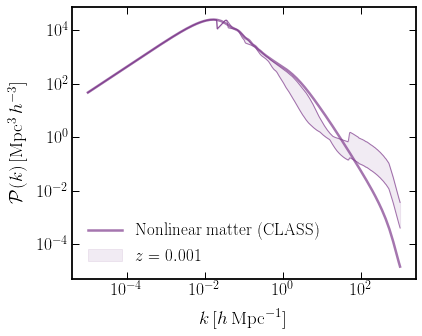

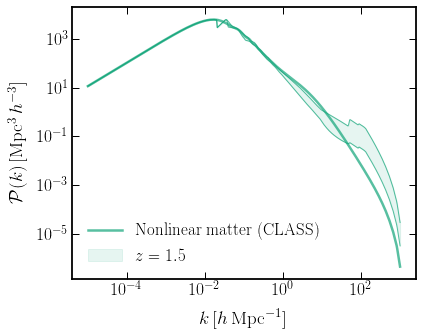

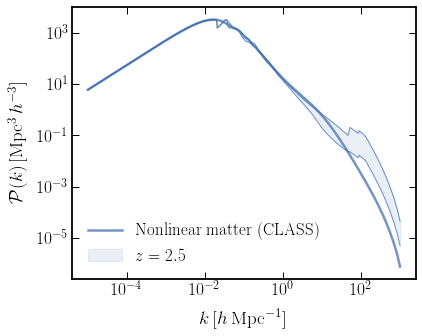

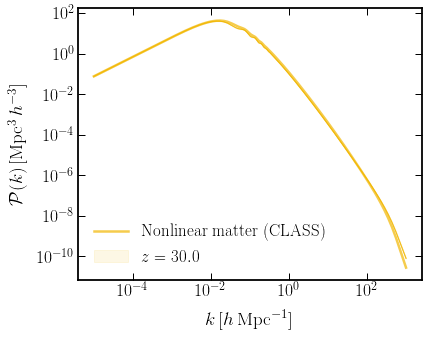

In [56]:
z_grid_ary = np.array([1e-3, 1.5, 2.5, 30]) # Redshift grid
k_grid_ary = np.logspace(-5, 3, 1000) # k grid

log_pk_lower_grid = log_pk_franken_lower_interp_fn(z_grid_ary, k_grid_ary)
log_pk_upper_grid = log_pk_franken_upper_interp_fn(z_grid_ary, k_grid_ary)

z, k, Pk, Delta2,  = np.transpose(np.loadtxt("../data/powtable_BAHAMAS_nu0_WMAP9_bar.dat"))
k = k[z==0]
Pk = Pk[z==0] / (WMAP9.Ob0 / WMAP9.Om0) ** 2

for iz in range(len(z_grid_ary)):
    
    plt.figure()
    
    plt.fill_between(k_grid_ary, 10 ** log_pk_lower_grid[iz], 10 ** log_pk_upper_grid[iz], alpha=0.1, color=cols_default[iz], label="$z=" + str(z_grid_ary[iz]) + "$");
    plt.plot(k_grid_ary, 10 ** log_pk_lower_grid[iz], color=cols_default[iz], lw=1)
    plt.plot(k_grid_ary, 10 ** log_pk_upper_grid[iz], color=cols_default[iz], lw=1)
    
    # The nonlinear PS from CLASS
    plt.plot(k_grid_ary, 10 ** log_pk_nonlin_matter_bj_interp([z_grid_ary[iz]], k_grid_ary)[0], color=cols_default[iz], label='Nonlinear matter (CLASS)')

    plt.xlabel("$k\,[h\,\mathrm{Mpc}^{-1}]$")
    plt.ylabel("$\mathcal P(k)$\,[Mpc$^3$\,$h^{-3}$]")

    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    

# 4. Get baryon Jeans scale

In [57]:
ratio = lambda z, k: 10 ** log_pk_nonlin_matter_bj_interp([z], [k])[0, 0] / 10 ** log_pk_nonlin_matter_interp([z], [k])[0, 0]

z_ary = np.logspace(-3, np.log10(200.), 200)
k_b_J_ary = np.zeros_like(z_ary)

for i_z, z in enumerate(tqdm_notebook(z_ary)):
    k_b_J_ary[i_z] = minimize(lambda k: np.abs(ratio(z , k) - (1 / np.e)), x0=300., bounds=[[100, 5000]]).x[0]

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Text(0.5, 1.0, 'Baryon jeans scale, numerical')

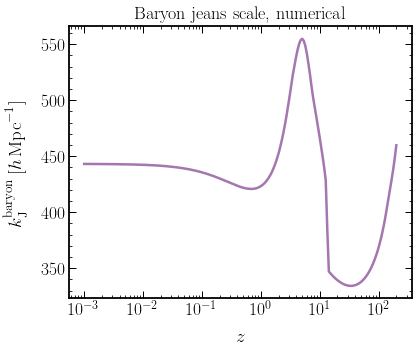

In [58]:
plt.plot(z_ary, k_b_J_ary)
plt.xscale("log")

plt.xlabel("$z$")
plt.ylabel(r"$k_\mathrm{J}^\mathrm{baryon}\,[h\,\mathrm{Mpc}^{-1}$]")

plt.title("Baryon jeans scale, numerical")

In [59]:
np.savetxt("../data/k_bJ_ary.dat", np.transpose([z_ary, k_b_J_ary]))

# 4.x Baryon Jeans from `CLASS`

In [5]:
from classy import Class

common_settings = {'output' : 'tCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'n_s':0.9619,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   'thermodynamics_verbose':1
                   }  
##############
#    
# call CLASS
#
###############
M = Class()
M.set(common_settings)
M.compute()
derived = M.get_current_derived_parameters(['tau_rec','conformal_age'])
thermo = M.get_thermodynamics()

In [11]:
H = np.array([M.Hubble(z) for z in thermo['z']])
a = 1 / (1 + thermo['z'])
c_b = np.sqrt(thermo['c_b^2'])

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, '$k_\\mathrm{J}^\\mathrm{baryon}\\,[h\\,\\mathrm{Mpc}^{-1}$]')

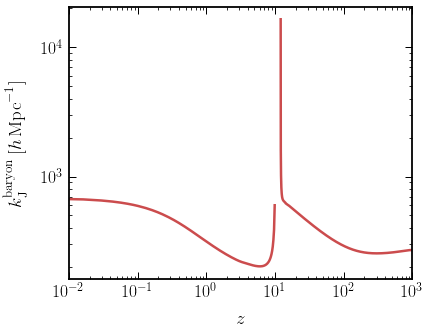

In [14]:
plt.plot(thermo['z'], a * H / c_b)
plt.xscale("log")
plt.yscale("log")

plt.xlim(1e-2, 1e3)

plt.xlabel("$z$")
plt.ylabel(r"$k_\mathrm{J}^\mathrm{baryon}\,[h\,\mathrm{Mpc}^{-1}$]")

Text(0, 0.5, '$T_b$\\, [K]')

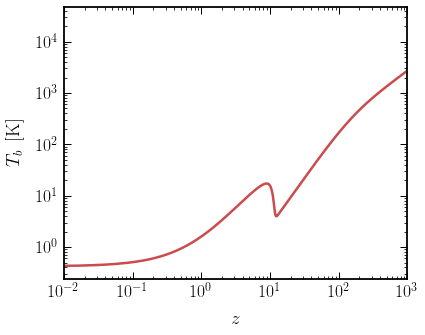

In [13]:
plt.plot(thermo['z'], thermo['Tb [K]'])
plt.xscale("log")
plt.yscale("log")

plt.xlim(1e-2, 1e3)
plt.xlabel("$z$")
plt.ylabel("$T_b$\, [K]")

# 5. Load and save vanilla pre-computed PSs from `CLASS`
## Including $x_e$ perturbations

In [22]:
z_compute_ary = np.logspace(-3, 3, 500)
k_ary = np.logspace(-4, np.log10(5e3), 1000)

log_pk_lin_baryon_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_pk_lin_electron_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_pk_lin_baryon_electron_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))

log_pk_lin_baryon_og_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_pk_lin_baryon_og_k3_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))

for i_z, z_compute in enumerate(tqdm_notebook(z_compute_ary)):
    
    ary = np.load("../data/pk_arys/p_k_chi_k_max_500_z_" + str(i_z) + ".npz")
    ary_og = np.load("../data/pk_arys/p_k_k_max_5000_z_" + str(i_z) + ".npz")
    
    interp_lin_baryon_og = interp1d(np.log10(ary_og['k_ary']), np.log10(ary_og['Pk_b_ary']), bounds_error=False, fill_value="extrapolate")
    interp_lin_baryon_og_k3 = interp1d(np.log10(ary_og['k_ary'][ary_og['k_ary'] < 10]), np.log10(ary_og['Pk_b_ary'])[ary_og['k_ary'] < 10], bounds_error=False, fill_value="extrapolate")

    interp_lin_baryon = interp1d(np.log10(ary['k_ary'][ary['k_ary'] < 10]), np.log10(ary['Pk_b_ary'][ary['k_ary'] < 10]), bounds_error=False, fill_value="extrapolate")
    log_pk_lin_baryon_grid_ary[i_z,:] = (interp_lin_baryon(np.log10(k_ary)))

    interp_lin_electron = interp1d(np.log10(ary['k_ary'][ary['k_ary'] < 10]), np.log10(ary['Pk_e_ary'][ary['k_ary'] < 10]), bounds_error=False, fill_value="extrapolate")
    log_pk_lin_electron_grid_ary[i_z,:] = (interp_lin_electron(np.log10(k_ary)))

    interp_lin_baryon_electron = interp1d(np.log10(ary['k_ary'][ary['k_ary'] < 10]), np.log10(ary['Pk_e_b_ary'])[ary['k_ary'] < 10], bounds_error=False, fill_value="extrapolate")
    log_pk_lin_baryon_electron_grid_ary[i_z,:] = (interp_lin_baryon_electron(np.log10(k_ary)))
    
    log_pk_lin_baryon_og_grid_ary[i_z,:] = (interp_lin_baryon_og(np.log10(k_ary)))
    log_pk_lin_baryon_og_k3_grid_ary[i_z,:] = (interp_lin_baryon_og_k3(np.log10(k_ary)))

#     print(ary['Pk_e_b_ary'])
#     print(z_compute_ary[i_z], np.sum(np.isnan(np.log10(ary['Pk_e_b_ary']))), np.sum(np.isnan(interp_lin_baryon_electron(np.log10(k_ary)))))


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10


In [23]:
supp_rat = log_pk_lin_baryon_og_grid_ary / log_pk_lin_baryon_og_k3_grid_ary

In [24]:
idx = 450

z_compute_ary[idx]

257.52633267711985

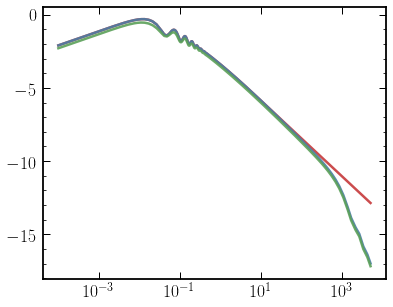

In [25]:
plt.plot(k_ary, log_pk_lin_baryon_grid_ary[idx])
plt.plot(k_ary, log_pk_lin_baryon_og_grid_ary[idx])
plt.plot(k_ary, (supp_rat * log_pk_lin_baryon_electron_grid_ary)[idx])
plt.xscale("log")

In [26]:
np.savez("../data/log_pk_grids/log_pk_lin_baryon_500_grid_ary.npz", 
        log_pk_grid=log_pk_lin_baryon_grid_ary,
        z_grid=z_compute_ary,
        k_grid=k_ary)

np.savez("../data/log_pk_grids/log_pk_lin_electron_500_grid_ary.npz", 
        log_pk_grid=log_pk_lin_electron_grid_ary,
        z_grid=z_compute_ary,
        k_grid=k_ary)

np.savez("../data/log_pk_grids/log_pk_lin_baryon_electron_500_grid_ary.npz", 
        log_pk_grid=np.nan_to_num(log_pk_lin_baryon_electron_grid_ary, nan=-100.),
        z_grid=z_compute_ary,
        k_grid=k_ary)

In [27]:
z_compute_ary = np.logspace(-3, 3, 500)
k_ary = np.logspace(-4, np.log10(5e3), 1000)

log_pk_lin_baryon_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_pk_lin_electron_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_pk_lin_baryon_electron_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))

log_pk_lin_baryon_og_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))
log_pk_lin_baryon_og_k3_grid_ary = np.zeros((len(z_compute_ary), len(k_ary)))

for i_z, z_compute in enumerate(tqdm_notebook(z_compute_ary)):
    
    ary = np.load("../data/pk_arys/p_k_chi_k_max_500_z_" + str(i_z) + ".npz")
    ary_og = np.load("../data/pk_arys/p_k_k_max_5000_z_" + str(i_z) + ".npz")
    
    interp_lin_baryon_og = interp1d(np.log10(ary_og['k_ary']), np.log10(ary_og['Pk_b_ary']), bounds_error=False, fill_value="extrapolate")
    interp_lin_baryon_og_k3 = interp1d(np.log10(ary_og['k_ary'][ary_og['k_ary'] < 10]), np.log10(ary_og['Pk_b_ary'])[ary_og['k_ary'] < 10], bounds_error=False, fill_value="extrapolate")

    interp_lin_baryon = interp1d(np.log10(ary['k_ary'][ary['k_ary'] < 10]), np.log10(ary['Pk_b_ary'][ary['k_ary'] < 10]), bounds_error=False, fill_value="extrapolate")
    log_pk_lin_baryon_grid_ary[i_z,:] = (interp_lin_baryon(np.log10(k_ary)))

    interp_lin_electron = interp1d(np.log10(ary['k_ary'][ary['k_ary'] < 10]), np.log10(ary['Pk_chi_ary'][ary['k_ary'] < 10]), bounds_error=False, fill_value="extrapolate")
    log_pk_lin_electron_grid_ary[i_z,:] = (interp_lin_electron(np.log10(k_ary)))

    interp_lin_baryon_electron = interp1d(np.log10(ary['k_ary'][ary['k_ary'] < 10]), np.log10(ary['Pk_chi_b_ary'])[ary['k_ary'] < 10], bounds_error=False, fill_value="extrapolate")
    log_pk_lin_baryon_electron_grid_ary[i_z,:] = (interp_lin_baryon_electron(np.log10(k_ary)))
    
    log_pk_lin_baryon_og_grid_ary[i_z,:] = (interp_lin_baryon_og(np.log10(k_ary)))
    log_pk_lin_baryon_og_k3_grid_ary[i_z,:] = (interp_lin_baryon_og_k3(np.log10(k_ary)))

#     print(ary['Pk_e_b_ary'])
#     print(z_compute_ary[i_z], np.sum(np.isnan(np.log10(ary['Pk_e_b_ary']))), np.sum(np.isnan(interp_lin_baryon_electron(np.log10(k_ary)))))


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10


In [29]:
supp_rat = log_pk_lin_baryon_og_grid_ary / log_pk_lin_baryon_og_k3_grid_ary

In [30]:
np.savez("../data/log_pk_grids/log_pk_lin_chi_500_grid_ary.npz", 
        log_pk_grid=log_pk_lin_electron_grid_ary,
        z_grid=z_compute_ary,
        k_grid=k_ary)

np.savez("../data/log_pk_grids/log_pk_lin_baryon_chi_500_grid_ary.npz", 
        log_pk_grid=np.nan_to_num(log_pk_lin_baryon_electron_grid_ary, nan=-100.),
        z_grid=z_compute_ary,
        k_grid=k_ary)